# 1. Install & Import 라이브러리

In [1]:
!python -m pip install selenium webdriver_manager pandas numpy konlpy tensorflow
!python -m pip install matplotlib python-pptx
!python -m pip install openpyxl

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from time import sleep
import pandas as pd
import numpy as np
import re
import json
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from datetime import datetime, timedelta


# 2. 경로 설정

In [2]:
PATH_POST_DATA_CSV = 'data_csv/post.csv'
PATH_MATCH_STAT_CSV = 'data_csv/match_stats.csv'
PATH_PLAYERS_TXT = 'data_txt/players.txt'
PATH_MATCH_INFO_PNG = 'data_match_info'
PATH_MATHH_DETAIL_XLS = 'data_match_detail'
PATH_ANALYSIS_HTML = 'data_analysis'

# 3. 함수 설정

In [3]:
def reading_file(file_path):
    encodings = ['cp949', 'utf-8', 'ISO-8859-1', 'cp1252']
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            return df
        except: pass
    return None

stop_words = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']
okt = Okt()
clean_train_review = []
def preprocessing(review, okt, remove_stopwords = False, stop_words =[]):
  review_text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]','',review)
  word_review = okt.morphs(review_text,stem=True)
  if remove_stopwords:
    word_review = [token for token in word_review if not token in stop_words]
  return word_review


# 3. 저장된 데이터 수집

### 3.1. 선수 정보 불러오기

In [4]:
# 선수이름이 저장된 TXT파일 불러오기
player_box = set()
with open(PATH_PLAYERS_TXT, 'r', encoding='utf-8') as f:
    for p in f.readlines():
        player_box.add(p.strip())

# player_box.remove('손흥민')
# player_box.remove('이강인')

# 불러온 선수 명단 출력
for i, player in enumerate(player_box):
    print(player, end = ' ')
    if (i+1)%10==0:
        print()

import json

a = {p:[] for p in player_box}

with open('data_json/nickname.json','w', encoding='utf-8') as f:
    json.dump(a,f)

황희찬 이동경 박민규 황인범 고승범 박용우 이명재 조영욱 권창훈 고영준 
이기제 정우영 김준홍 문선민 이재성 김동현 송범근 남태희 이창근 조유민 
양현준 이강인 박지수 정승현 정호연 구성윤 오현규 이영재 김영권 홍철 
김진규 이동준 황의조 김지수 원두재 손흥민 안현범 김태환 백승호 이순민 
이재익 김동준 나상호 손준호 이기혁 홍현석 윤종규 강성진 주민규 엄원상 
송민규 박규현 이상민 권경원 강상우 조규성 김승규 이용 박진섭 김민재 
김주성 설영우 김문환 조현우 김진수 

In [5]:
# 별명
with open('data_json/nickname.json','r') as f:
    nicks = json.load(f)

nick_to_name = {}
for name, nick in nicks.items():
    for nk in nick:
        nick_to_name[nk] = name



### 3.2. 게시글 파일 불러오기

In [6]:
df_post = reading_file(PATH_POST_DATA_CSV)
df_post

,DATE_TIME,POST
0,2024-03-23 01:41:09,이강인 대국민사과 때 보면 그냥 손흥민은 진짜 이해가 안됨
1,2024-03-23 01:41:02,놀라운건 이게 모두
2,2024-03-23 01:41:01,창민이 요즘 제어가 안되는거 같다
3,2024-03-23 01:40:59,누가 더 잘생겼는지 평가좀
4,2024-03-23 01:40:51,헷갈리게 하는 여사친 만나고 왔는데..txt
...,...,...
39753,2022-12-30 23:59:56,"조지나 대리모 아들은 아르헨,포국 이중국적이잖음"
39754,2022-12-30 23:59:46,펠레는 앞으로 한세대만 지나도 그런새끼가 있었나? 취급일걸
39755,2022-12-30 23:59:44,10아르헨 독일 경기보면 개병신수준임
39756,2022-12-30 23:59:39,오현규가 아직 어려서 셀틱 명문 이지랄하고 있는데


### 3.3. 매치 정보 불러오기

In [7]:
df_match = reading_file(PATH_MATCH_STAT_CSV)
df_match

,DATE_TIME,Stadium,Korea,Opponent,Korea_score,Oppo_score
0,2022-01-15 20:00:00,터키 안탈리아 마르단 스타디움,남자 국가대표팀,아이슬란드,5,1
1,2022-01-21 20:00:00,터키 안탈리아 마르단 스타디움,남자 국가대표팀,몰도바,4,0
2,2022-01-27 21:00:00,레바논 사이다 무니시팔스타디움,남자 국가대표팀,레바논,1,0
3,2022-02-01 23:00:00,UAE 라시드 스타디움,남자 국가대표팀,시리아,2,0
4,2022-03-24 20:00:00,대한민국 서울월드컵경기장,남자 국가대표팀,이란,2,0
...,...,...,...,...,...,...
61,2024-11-11 20:00:00,대한민국 화성종합경기타운,남자 국가대표팀,아이슬란드,1,0
62,2024-11-24 22:00:00,카타르 에듀케이션 시티 스타디움,남자 국가대표팀,우루과이,0,0
63,2024-11-28 22:00:00,카타르 에듀케이션 시티 스타디움,남자 국가대표팀,가나,2,3
64,2024-12-03 00:00:00,카타르 에듀케이션 시티 스타디움,남자 국가대표팀,포르투갈,2,1


In [8]:
import pandas as pd
import os

detail_box = {}
SAMPLE = True
for file_name in os.listdir(PATH_MATHH_DETAIL_XLS):
    file_path = PATH_MATHH_DETAIL_XLS + '/' + file_name
    detail_box[file_name] = pd.read_excel(file_path)
    if SAMPLE:
        print(file_name)
        df = detail_box[file_name]
        display(detail_box[file_name])
        SAMPLE = False

230324_콜롬비아.xlsx


,선수 이름,평점,출전 시간,득점,어시스트,전체 유효 슈팅,기회 창출,정확한 패스
0,손흥민,9.2,90,2,0,4,2,23/31 (74%)
1,이재성,8.2,69,0,1,0,3,18/21 (86%)
2,이기제,7.0,66,0,0,1,0,25/27 (93%)
3,김태환,6.9,90,0,0,0,0,28/33 (85%)
4,이강인,6.9,30,0,0,0,0,15/16 (94%)
5,황인범,6.8,90,0,0,2,0,44/52 (85%)
6,김영권,6.8,90,0,0,0,0,57/61 (93%)
7,정우영,6.5,60,0,0,1,0,10/12 (83%)
8,김민재,6.4,90,0,0,0,0,56/63 (89%)
9,조규성,6.3,60,0,0,0,0,9/13 (69%)


### 3.4. 경기 시간 기준, 36시간 이내 선수이름 언급 빈도

In [9]:
# 게시글 기록 시간 범위
begin = df_post['DATE_TIME'].min()
end = df_post['DATE_TIME'].max()

# 빈도 계산
match_post = []
for i in range(len(df_match)):
    # 진행률
    progress = f'{100*(i+1)/len(df_match):.2f}'
    print(f'\r{progress}%, {i+1}/{len(df_match)}', end='')

    # 매치 정보
    match_info = df_match.iloc[i]
    match_time = match_info['DATE_TIME']

    # 집계
    if begin <= match_time <= end: # 범위 내의 데이터 한정
        # 경기시간 기준 36시간 이내 게시글 수집
        time_value = datetime.strptime(match_time, '%Y-%m-%d %H:%M:%S')
        match_time_later = str(time_value + timedelta(hours=36))
        indexes = df_post[(df_post['DATE_TIME'] >= match_time) & (df_post['DATE_TIME'] < match_time_later)].index

        # 빈도 계산   
        if len(indexes) > 0:
            frequency = {}
            for index in indexes:
                post = df_post['POST'][index]
                for word in preprocessing(post ,okt,remove_stopwords=True,stop_words= stop_words):
                    if word in nick_to_name:
                        word = nick_to_name[word]
                    
                    if not word in player_box:
                        continue
                    if not word in frequency:
                        frequency[word] = 1
                    frequency[word] += 1
            sorted_frequency = sorted(frequency.items(), key=lambda x: x[1], reverse=True)

            match_post.append([match_info, sorted_frequency])



100.00%, 66/66

In [10]:
for m in match_post:
    if m[0]['Opponent'] == '이라크':
        print('sekfnk')
    continue
    print(m[0]['Oppo_score'])
    

sekfnk
sekfnk


# 4. 분석 결과 출력

### 4.1. 그래프 이미지 생성 -> data_match_info 로 저장

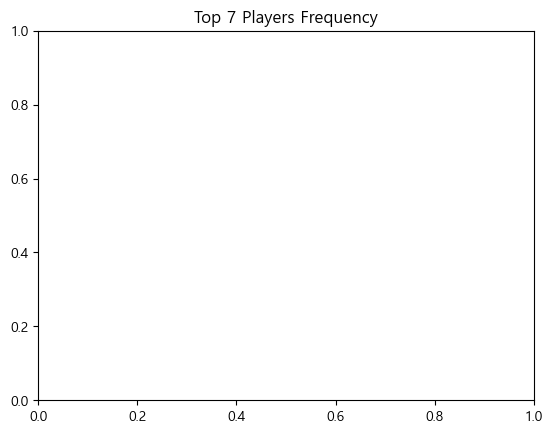

In [11]:
import matplotlib.pyplot as plt

# 한글 폰트 및 마이너스 기호 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
match_result = {}

def frequency_graph(index, match_post):
    try:
        match_info, frequency = match_post[index]

        match_date = match_info['DATE_TIME'].split()[0]
        match_tadium = match_info['Stadium']
        opponent = match_info['Opponent']
        korea_score = match_info['Korea_score']
        oppo_score = match_info['Oppo_score']

        if len(frequency) >= 7:
            top_7 = frequency[:7]
            explode = (0.1, 0, 0, 0, 0, 0, 0)
            colors = plt.get_cmap('Pastel1')(np.linspace(0.2, 0.7, len(top_7)))
            players, scores = zip(*top_7)
            plt.title('Top 7 Players Frequency')
        elif len(frequency) == 6:
            top_6 = frequency[:6]
            explode = (0.1, 0, 0, 0, 0, 0)
            colors = plt.get_cmap('Pastel1')(np.linspace(0.2, 0.7, len(top_6)))
            players, scores = zip(*top_6)
            plt.title('Top 6 Players Frequency')
        elif len(frequency) == 5:
            top_5 = frequency[:5]
            explode = (0.1, 0, 0, 0, 0)
            colors = plt.get_cmap('Pastel1')(np.linspace(0.2, 0.7, len(top_5)))
            players, scores = zip(*top_5)
            plt.title('Top 5 Players Frequency')

        match_type = match_info['Korea']
        if match_type != '남자 국가대표팀':
            print(opponent)
            return

        # 그래프 설정
        plt.figure(figsize=(10, 6))
        plt.pie(scores, labels=players, autopct='%1.1f%%', startangle=140, explode=explode, shadow=True, colors=colors)
        
        # match_info 정보를 텍스트로 추가
        match_info_txt = f"{match_date}\n Korea vs {opponent}\n{korea_score} : {oppo_score}"

        plt.annotate(match_info_txt, xy=(1, 0), xycoords='axes fraction', fontsize=10, xytext=(-20, 20), textcoords='offset points', ha='right', va='bottom')
        
        # 파일 저장
        match_date_txt = ''.join(match_date.split('-'))[2::]
    
        file_name = f'{match_date_txt}_{opponent}'
        if korea_score > oppo_score:
            match_result[file_name] = 'WIN'
        elif korea_score < oppo_score:
            match_result[file_name] = 'LOSE'
        else: # korea_score == oppo_score
            match_result[file_name] = 'DRAW'

        plt.savefig(f'{PATH_MATCH_INFO_PNG}/{file_name}.png', bbox_inches='tight')
        plt.close()

    except Exception as e:
        plt.close()
        
for i in range(len(match_post)):
    frequency_graph(i, match_post)


In [12]:
match_result

{'230324_콜롬비아': 'DRAW',
 '230328_우루과이': 'LOSE',
 '230616_페루': 'LOSE',
 '230620_엘살바도르': 'DRAW',
 '230908_웨일스': 'DRAW',
 '230913_사우디아라비아': 'WIN',
 '231013_튀니지': 'WIN',
 '231017_베트남': 'WIN',
 '231116_싱가포르': 'WIN',
 '231121_중국': 'WIN',
 '240106_이라크': 'WIN',
 '240115_아이슬란드': 'WIN',
 '240115_바레인': 'WIN',
 '240120_요르단': 'DRAW',
 '240125_말레이시아': 'DRAW',
 '240131_사우디아라비아': 'WIN',
 '240201_시리아': 'WIN',
 '240203_호주': 'WIN',
 '240207_요르단': 'LOSE',
 '240321_태국': 'DRAW'}

### 4.2. HTML파일 생성

In [13]:
def make_html(df, file_name):
    html_str = df.to_html(index=False)
    img_path = f'../{PATH_MATCH_INFO_PNG}/{file_name}.png'
    result = match_result[file_name]
    html_file_path = f'{PATH_ANALYSIS_HTML}/{file_name}({result}).html'
    with open(html_file_path, 'w', encoding='utf-8') as f:
        f.write("""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Table and Image Example</title>
        <style>
            .table-container {
                float: left;
                width: 50%;
            }
            .image-container {
                float: right;
                width: 50%;
            }
            table, th, td {
                border: 1px solid black;
                border-collapse: collapse;
                font-size: 0.8em;
            }
            th, td {
                padding: 5px; 
                text-align: left;
            }
            img {
                max-width: 100%; 
                height: auto; 
            }
        </style>
    </head>
    <body>
        <div class="table-container">""" + html_str + """</div>
        <div class="image-container">
            <img src=\"""" + img_path + """\" alt="Match Image">
        </div>
    </body>
    </html>
    """)

for png_file_name in os.listdir(PATH_MATCH_INFO_PNG):
    file_name = png_file_name.split('.')[0]

    if f'{file_name}.xlsx' in detail_box:
        df = detail_box[f'{file_name}.xlsx']
        make_html(df, file_name)
